# Recommendation Systems Assignment

### MIE451/1513 UofT

### Getting MovieLens data

* Download the movielens 100k dataset from this link: [ml-100k.zip](http://files.grouplens.org/datasets/movielens/ml-100k.zip)

* Upload ml-100k.zip

* Extract using the following cell:

### Imports

In [2]:
# import required libraries
import os
import os.path
import numpy as np
import pandas as pd
from math import sqrt
from heapq import nlargest
from tqdm import trange
from tqdm import tqdm
from scipy import stats
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import mean_squared_error

## Support functions and variables

In [3]:
#!unzip ml-100k.zip -d .

In [4]:
MOVIELENS_DIR = "ml-100k"

In [5]:
!ls {MOVIELENS_DIR}

README
allbut.pl
mku.sh
u.data
u.genre
u.info
u.item
u.occupation
u.user
u1.base
u1.test
u2.base
u2.test
u3.base
u3.test
u4.base
u4.test
u5.base
u5.test
ua.base
ua.test
ub.base
ub.test


In [6]:
def getData(folder_path, file_name):
    fields = ['userID', 'itemID', 'rating', 'timestamp']
    data = pd.read_csv(os.path.join(folder_path, file_name), sep='\t', names=fields)
    return data 

In [7]:
rating_df = getData(MOVIELENS_DIR, 'u.data')

In [8]:
num_users = len(rating_df.userID.unique())
num_items = len(rating_df.itemID.unique())
print("Number of users:", num_users)
print("Number of items:", num_items)

Number of users: 943
Number of items: 1682


## Q1

### (a)

In [10]:
def dataPreprocessor(rating_df, num_users, num_items):
    """
        INPUT: 
            data: pandas DataFrame. columns=['userID', 'itemID', 'rating' ...]
            num_row: int. number of users
            num_col: int. number of items
            
        OUTPUT:
            matrix: 2D numpy array. 
            
        NOTE 1: see where something very similar is done in the lab in function 'buildUserItemMatrix'    
            
        NOTE 2: data can have more columns, but your function should ignore 
              additional columns.
    """
    ########### your code goes here ###########
    matrix = np.zeros((num_users, num_items))
    # Populate the matrix based on the dataset
    for (index, userID, itemID, rating, timestamp) in rating_df.itertuples():
        matrix[userID-1, itemID-1] = rating
    
    
    ###########         end         ###########
    return matrix

In [11]:
dataPreprocessor(rating_df, num_users, num_items)

array([[5., 3., 4., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 0., 0.]])

### (b)

In [13]:
class BaseLineRecSys(object):
    def __init__(self, method, processor=dataPreprocessor):
        """
            method: string. From ['popularity','useraverage']
            processor: function name. dataPreprocessor by default
        """
        self.method_name = method
        self.method = self._getMethod(self.method_name)
        self.processor = processor
        self.pred_column_name = self.method_name
        
    def _getMethod(self, method_name):
        """
            Don't change this
        """
        switcher = {
            'popularity': self.popularity,
            'useraverage': self.useraverage,
        }
        
        return switcher[method_name]
    
    @staticmethod
    def useraverage(train_matrix, num_users, num_items):
        """
            INPUT:
                train_matrix: 2D numpy array.
                num_users: int. Number of Users.
                num_items: int. Number of Items.
            OUTPUT:
                predictionMatrix: 2D numpy array.
                
            NOTE: see where something very similar is done in the lab in function 'predictByUserAverage'    
        """
        
        predictionMatrix = np.zeros((num_users, num_items))
        ########### your code goes here ###########
        # Initialize the predicted rating matrix with zeros
        for (user,item), rating in np.ndenumerate(train_matrix):
        # Predict rating for every item that wasn't ranked by the user (rating == 0)
            #if rating == 0:
            # Extract the items the user already rated
            userVector = train_matrix[user, :]
            ratedItems = userVector[userVector.nonzero()]

            # If not empty, calculate average and set as rating for the current item
            if ratedItems.size == 0: #not sure
                itemAvg = 0
            else:
                itemAvg = ratedItems.mean()
            predictionMatrix[user, item] = itemAvg

            # report progress every 100 users
            if (user % 100 == 0 and item == 1):
                print ("calculated %d users" % (user,))       


        ###########         end         ###########
        return predictionMatrix
    
    @staticmethod
    def popularity(train_matrix, num_users, num_items):
        """
            INPUT:
                train_matrix: 2D numpy array.
                num_users: int. Number of Users.
                num_items: int. Number of Items.
            OUTPUT:
                predictionMatrix: 2D numpy array.
                
            NOTE: see where something very similar is done in the lab in function 'predictByPopularity'    
        """
        
        predictionMatrix = np.zeros((num_users, num_items))
        ########### your code goes here ###########
        # Initialize the predicted rating matrix with zeros
        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        # For every item calculate the number of people liked (4-5) divided by the number of people that rated
        itemPopularity = np.zeros((num_items))
        for item in range(num_items):
            numOfUsersRated = len(train_matrix[:, item].nonzero()[0])
            numOfUsersLiked = len(vf(train_matrix[:, item]).nonzero()[0])
            if numOfUsersRated == 0:
                itemPopularity[item] = 0
            else:
                itemPopularity[item] = numOfUsersLiked/numOfUsersRated

        for (user,item), rating in np.ndenumerate(train_matrix):
            # Predict rating for every item that wasn't ranked by the user (rating == 0)
#             if rating == 0:
            predictionMatrix[user, item] = itemPopularity[item]
                

            # report progress every 100 users
            if (user % 100 == 0 and item == 1):
                print ("calculated %d users" % (user,))         

                
        ###########         end         ###########
        return predictionMatrix    
    
    def predict_all(self, train_df, num_users, num_items):
        
        train_matrix = self.processor(train_df, num_users, num_items)
        self.__model = self.method(train_matrix, num_users, num_items)
        
    def evaluate_test(self, test_df, copy=False):
        
        if copy:
            prediction = test_df.copy()
        else:
            prediction = test_df
            
        prediction[self.pred_column_name] = np.nan
        
        for (index, 
             userID, 
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = self.__model[userID-1, itemID-1]

        return prediction
        
    def getModel(self):
        """
            return predicted user-item matrix
        """
        return self.__model
    
    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name
    
    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        try:
            self.model = None
        except:
            print("You don not have model..")
            

In [14]:
popularity_recsys = BaseLineRecSys('popularity')

In [15]:
popularity_recsys.predict_all(rating_df, num_users, num_items)

calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


In [16]:
x = popularity_recsys.getModel()

In [17]:
np.all(x<=1)

True

In [18]:
rating_df.head()

,userID,itemID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [19]:
popularity_recsys.evaluate_test(rating_df,copy=True).head()

100000it [00:56, 1779.89it/s]


,userID,itemID,rating,timestamp,popularity
0,196,242,3,881250949,0.760684
1,186,302,3,891717742,0.804714
2,22,377,1,878887116,0.076923
3,244,51,2,880606923,0.555556
4,166,346,1,886397596,0.611111


In [20]:
average_user_rating_recsys = BaseLineRecSys('useraverage')

In [21]:
average_user_rating_recsys.predict_all(rating_df, num_users, num_items)

calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


In [22]:
average_user_rating_recsys.getModel()

array([[3.61029412, 3.61029412, 3.61029412, ..., 3.61029412, 3.61029412,
        3.61029412],
       [3.70967742, 3.70967742, 3.70967742, ..., 3.70967742, 3.70967742,
        3.70967742],
       [2.7962963 , 2.7962963 , 2.7962963 , ..., 2.7962963 , 2.7962963 ,
        2.7962963 ],
       ...,
       [4.04545455, 4.04545455, 4.04545455, ..., 4.04545455, 4.04545455,
        4.04545455],
       [4.26582278, 4.26582278, 4.26582278, ..., 4.26582278, 4.26582278,
        4.26582278],
       [3.41071429, 3.41071429, 3.41071429, ..., 3.41071429, 3.41071429,
        3.41071429]])

In [23]:
average_user_rating_recsys.evaluate_test(rating_df,copy=True).head()

100000it [01:00, 1641.85it/s]


,userID,itemID,rating,timestamp,useraverage
0,196,242,3,881250949,3.615385
1,186,302,3,891717742,3.413043
2,22,377,1,878887116,3.351562
3,244,51,2,880606923,3.651261
4,166,346,1,886397596,3.550000


## Q2

### (a)

In [25]:
class SimBasedRecSys(object):

    def __init__(self, base, method, processor=dataPreprocessor):
        """
            base: string. From ['user', 'item']. User-based Similarity or Item-based
            method: string. From ['cosine', 'euclidean', 'somethingelse']
            processor: function name. dataPreprocessor by default
        """
        self.base = base
        self.method_name = method
        self.method = self._getMethod(self.method_name)
        self.processor = processor
        self.pred_column_name = self.base+'-'+self.method_name
    
    def _getMethod(self, method_name):
        """
            Don't change this
        """
        switcher = {
            'cosine': self.cosine,
            'euclidean': self.euclidean,
            'somethingelse': self.somethingelse,
        }
        
        return switcher[method_name]
    
    @staticmethod
    def cosine(matrix):
        """
            cosine similarity
        """
        similarity_matrix = 1 - pairwise_distances(matrix, metric='cosine')
        return similarity_matrix
    
    @staticmethod
    def euclidean(matrix):
        """
            euclidean similarity
        """
        ########### your code goes here ###########

        similarity_matrix = 1/(pairwise_distances(matrix, metric = 'euclidean') + 1 )
    
        ###########         end         ###########    
        
        return similarity_matrix
    
    @staticmethod
    def somethingelse(matrix):
        """
            manhattan? or super-natural intuition similarity
        """
        ########### your code goes here ###########
        
        similarity_matrix = 1/(pairwise_distances(matrix, metric = 'manhattan') + 1 )
    
        ###########         end         ###########        
        return similarity_matrix
        
    def predict_all(self, train_df, num_users, num_items):
        """
            INPUT: 
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
                num_row: scalar. number of users
                num_col: scalar. number of items
            OUTPUT:
                no return... this method assigns the result to self.model
            
            NOTES:
                self.__model should contain predictions for *all* user and items
                (don't worry about predicting for observed (user,item) pairs,
                 since we won't be using these predictions in the evaluation)
                (see code in for an efficient vectorized example)
        """
        train_matrix = self.processor(train_df, num_users, num_items)
        
        if self.base == 'user':
            ########### your code goes here ###########
            #generate a same size matrix as train_matrix with 0s
            temp_matrix = np.zeros(train_matrix.shape)
            
            # add 1s if user has already rated a movie (no need to normalize later)
            temp_matrix[train_matrix.nonzero()] = 1
            
            # calculate user user similarity
            uu_similarity = self.method(train_matrix)
            
            #calculater normalizer (denominator) - sum of all other user's similarity to target user's target movie 
            normalizer = np.matmul(uu_similarity, temp_matrix)
            
            # need to add a small number for normalizer to avoid dividing by 0
            normalizer[normalizer==0] =1e-5
            
            # matrix multiplication - user-similarity * their rating, and normalize
            predictionMatrix = np.matmul(uu_similarity, train_matrix)/normalizer
            
            # calculate user average for later use(in case no one rated a movie, use user average)
            useraverage = np.sum(train_matrix, axis=1)/(np.sum(temp_matrix, axis=1) + 1e-5)
            
            # sum up predicted ratings for each item (identify items with 0 ratings)
            columns = np.sum(predictionMatrix, axis=0)
            
            # for those with 0 ratings, assign user's average rating
            predictionMatrix[:, columns==0] = predictionMatrix[:, columns==0] + np.expand_dims(useraverage, axis=1)
             
            self.__model = predictionMatrix
            
            ###########         end         ###########
            
        elif self.base == 'item':
            ########### your code goes here ###########
            # turn 943 * 1682 into 1682 * 943
            train_matrix = train_matrix.T
            
            #generate a same size matrix as train_matrix with 0s
            temp_matrix = np.zeros(train_matrix.shape)
            
            # add 1s if user has already rated a movie (no need to normalize later)
            temp_matrix[train_matrix.nonzero()] = 1
            
            # 1682 * 1682
            ii_similarity = self.method(train_matrix)
            
            normalizer = np.matmul(ii_similarity, temp_matrix)
            normalizer[normalizer==0] = 1e-5
            predictionMatrix = np.matmul(ii_similarity, train_matrix)/normalizer
            
            itemaverage = np.sum(train_matrix, axis=1)/(np.sum(temp_matrix, axis=1) + 1e-5)
            columns = np.sum(predictionMatrix, axis=0)
            predictionMatrix[:, columns==0] = predictionMatrix[:, columns==0] + np.expand_dims(itemaverage, axis=1)
                
            self.__model = predictionMatrix.T
                    
            ###########         end         ###########
        else:
            print('No other option available')
        
        
    def evaluate_test(self, test_df, copy=False):
        """
            INPUT:
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
            OUTPUT:
                predictions:  pandas DataFrame. 
                              columns=['userID', 'itemID', 'rating', 'base-method'...]
                              
            NOTE: 1. data can have more columns, but your function should ignore 
                  additional columns.
                  2. 'base-method' depends on your 'base' and 'method'. For example,
                  if base == 'user' and method == 'cosine', 
                  then base-method == 'user-cosine'
                  3. your predictions go to 'base-method' column
        """
        if copy:
            prediction = test_df.copy()
        else:
            prediction = test_df
        prediction[self.pred_column_name] = np.nan
        
        for (index, 
             userID, 
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = self.__model[userID-1, itemID-1]
    
        return prediction
    
    def getModel(self):
        """
            return predicted user-item matrix
        """
        return self.__model
    
    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name
    
    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        try:
            self.model = None
        except:
            print("You do not have model..")

In [26]:
# Examples of how to call similarity functions.
I = np.eye(3)
SimBasedRecSys.cosine(I)

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [27]:
SimBasedRecSys.euclidean(I)

array([[1.        , 0.41421356, 0.41421356],
       [0.41421356, 1.        , 0.41421356],
       [0.41421356, 0.41421356, 1.        ]])

In [28]:
SimBasedRecSys.somethingelse(I)

array([[1.        , 0.33333333, 0.33333333],
       [0.33333333, 1.        , 0.33333333],
       [0.33333333, 0.33333333, 1.        ]])

**Euclicean dependends on the vector size, Cosine is better with considering angel differences between feature vectors.**

### (b)

**Manhattan may be appropriate if different dimensions are not comparable. It takes the absolute difference of each item for two users. But being sensitive to outliers.**

## Q3

### (a)

In [29]:
user_cosine_recsys = SimBasedRecSys('user','cosine')

In [30]:
user_cosine_recsys.predict_all(rating_df, num_users, num_items)

In [31]:
user_cosine_recsys.getModel()

array([[3.89911175, 3.19022667, 3.0261129 , ..., 2.        , 3.        ,
        3.        ],
       [3.84034456, 3.17139889, 2.92626717, ..., 2.        , 3.        ,
        3.        ],
       [3.87104065, 3.12823798, 3.03250708, ..., 2.        , 3.        ,
        3.        ],
       ...,
       [3.90754645, 3.20227238, 3.05776201, ..., 2.        , 3.        ,
        3.        ],
       [3.91100649, 3.21591021, 2.98854017, ..., 2.        , 3.        ,
        3.        ],
       [3.91593122, 3.24268207, 3.08255897, ..., 0.        , 3.        ,
        3.        ]])

In [34]:
item_cosine_recsys = SimBasedRecSys('item','cosine')
item_cosine_recsys.predict_all(rating_df, num_users, num_items)
item_cosine_recsys.getModel()

array([[3.75429099, 3.66419957, 3.73222997, ..., 3.60248287, 3.79662696,
        3.90232044],
       [3.83658867, 3.80424519, 3.77473905, ..., 3.72798332, 3.9109779 ,
        3.79775927],
       [2.84492718, 2.89389328, 2.84327324, ..., 2.99504451, 3.16444153,
        2.9858119 ],
       ...,
       [4.11427954, 4.0558267 , 4.00963139, ..., 4.        , 3.87872799,
        4.14814803],
       [4.37096823, 4.39679254, 4.33543016, ..., 3.955358  , 4.41891089,
        4.57995134],
       [3.52030345, 3.46948821, 3.52393064, ..., 0.        , 3.6110641 ,
        3.59656861]])

In [32]:
rating_df.head()

,userID,itemID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [33]:
user_cosine_recsys.evaluate_test(rating_df,copy=True).head()

100000it [00:59, 1683.08it/s]


,userID,itemID,rating,timestamp,user-cosine
0,196,242,3,881250949,4.025213
1,186,302,3,891717742,4.142828
2,22,377,1,878887116,1.922080
3,244,51,2,880606923,3.431884
4,166,346,1,886397596,3.424963


### (b)

In [35]:
class CrossValidation(object):
    def __init__(self, metric, data_path=MOVIELENS_DIR):
        """
            INPUT:
                metric: string. from['RMSE','P@K','R@K']
        """
        self.folds = self._getData(MOVIELENS_DIR)
        self.metric_name = metric
        self.metric = self._getMetric(self.metric_name)
        
    def _getMetric(self, metric_name):
        """
            Don't change this
        """
        switcher = {
            'RMSE': self.rmse,
            'P@K': self.patk,
            'R@K': self.ratk,
        }
        
        return switcher[metric_name]
    
    @staticmethod
    def rmse(data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        return sqrt(mean_squared_error(data[pred], data[true]))
    
    # Precision at k
    def patk(self, data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            k: top-k items retrived
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        prediction = self.getMatrix(data, num_users, num_items, pred)
        testSet =  self.getMatrix(data, num_users, num_items, true)
    
        # Initialize sum and count vars for average calculation
        sumPrecisions = 0
        countPrecisions = 0

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        for userID in range(num_users):
            # Pick top K based on predicted rating
            userVector = prediction[userID,:]
            topK = nlargest(k, range(len(userVector)), userVector.take)

            # Convert test set ratings to like / don't like
            userTestVector = vf(testSet[userID,:]).nonzero()[0]

            # Calculate precision
            precision = float(len([item for item in topK if item in userTestVector]))/len(topK)

            # Update sum and count
            sumPrecisions += precision
            countPrecisions += 1

        # Return average P@k
        return float(sumPrecisions)/countPrecisions
    
    # Recall at k
    def ratk(self, data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            k: top-k items relevant
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        prediction = self.getMatrix(data, num_users, num_items, pred)
        testSet =  self.getMatrix(data, num_users, num_items, true)
        # Initialize sum and count vars for average calculation
        sumRecalls = 0
        countRecalls = 0

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        for userID in range(num_users):
            # Pick top K based on predicted rating
            userVector = prediction[userID,:]
            topK = nlargest(k, range(len(userVector)), userVector.take)

            # Convert test set ratings to like / don't like
            userTestVector = vf(testSet[userID,:]).nonzero()[0]

            # Ignore user if has no ratings in the test set
            if (len(userTestVector) == 0):
                continue

            # Calculate recall
            recall = float(len([item for item in topK if item in userTestVector]))/len(userTestVector)

            # Update sum and count
            sumRecalls += recall
            countRecalls += 1

        # Return average R@k
        return float(sumRecalls)/countRecalls
    
    @staticmethod
    def getMatrix(rating_df, num_users, num_items, column_name):
        matrix = np.zeros((num_users, num_items))
    
        for (index, userID, itemID, value) in rating_df[['userID','itemID', column_name]].itertuples():
            matrix[userID-1, itemID-1] = value
            
        return matrix
    
    @staticmethod
    def _getData(data_path):
        """
            Don't change this function
        """
        folds = []
        data_types = ['u{0}.base','u{0}.test']
        for i in range(1,6):
            train_set = getData(data_path, data_types[0].format(i))
            test_set = getData(data_path, data_types[1].format(i))
            folds.append([train_set, test_set])
        return folds
    
    def run(self, algorithms, num_users, num_items, k=1):
        """
            5-fold cross-validation
            algorithms: list. a list of algorithms. 
                        eg: [user_cosine_recsys, item_euclidean_recsys]
        """
        
        scores = {}
        for algorithm in algorithms:
            print('Processing algorithm {0}'.format(algorithm.getPredColName()))
            fold_scores = []
            for fold in self.folds:
                algorithm.reset()
                algorithm.predict_all(fold[0], num_users, num_items)
                prediction = algorithm.evaluate_test(fold[1])
                pred_col = algorithm.getPredColName()
                fold_scores.append(self.metric(prediction, k, num_users, num_items, pred_col))
                
            mean = np.mean(fold_scores)
            ci_low, ci_high = stats.t.interval(0.95, len(fold_scores)-1, loc=mean, scale=stats.sem(fold_scores))
            scores[algorithm.getPredColName()] = [fold_scores, mean, ci_low, ci_high]
            
        results = scores    
    
        return results
            

In [31]:
# How to use CrossValidation Class?

In [37]:
# 1. gather your algorithms in previous steps.
algorithm_instances = [user_cosine_recsys,
                       item_cosine_recsys]

In [38]:
# 2. Instantiate a CrossValidation instance and assign the measurement that you want to use
# RMSE, P@K, R@K
# Precision at K in this example
cv_rmse = CrossValidation('RMSE')

In [39]:
# 3. Run CV by giving:
#    1> algorithms just gathered
#    2> number of users in the full dataset
#    3> number of items in the full dataset
#    4> precision or recall at K need a K value, so k=5 means precision at 5 in this example
# Results include independent results from 5 folds, their mean, and confidence interval.
cv_rmse.run(algorithm_instances, num_users, num_items,k=5)

Processing algorithm user-cosine


20000it [00:09, 2177.74it/s]
20000it [00:09, 2222.20it/s]
20000it [00:09, 2208.36it/s]
20000it [00:09, 2158.28it/s]
20000it [00:09, 2211.61it/s]


Processing algorithm item-cosine


20000it [00:08, 2231.77it/s]
20000it [00:09, 2217.38it/s]
20000it [00:09, 2212.85it/s]
20000it [00:09, 2213.44it/s]
20000it [00:08, 2225.83it/s]


{'item-cosine': [[1.0377631264364244,
   1.0207280585350078,
   1.0101820660011798,
   1.0136832839209695,
   1.0180579656376574],
  1.020082900106248,
  1.0068242686250732,
  1.0333415315874226],
 'user-cosine': [[1.0264490128856898,
   1.0214387664092763,
   1.0132940323507253,
   1.009400399702741,
   1.0161883960008826],
  1.017354121469863,
  1.0090130800118484,
  1.0256951629278774]}

**user-user based cosine performs better , its simimarity matrix has lower dimention (943*943) so with the same features(rating), the feature matrix is denser, model will be trained under "more" data, structure(dimention) matters**

## Q4

### (a)

In [248]:
# 1. gather algorithms from previous steps.
algorithm_instances = [popularity_recsys, 
                       average_user_rating_recsys,
                       user_cosine_recsys,
                       item_cosine_recsys]
# 2. MSE, P@K, R@K
# Precision at K in this example
cv_rmse = CrossValidation('RMSE')
cv_patk = CrossValidation('P@K')
cv_ratk = CrossValidation('R@K')

In [249]:
# 3. Run CV by giving:
#    1> algorithms just gathered
#    2> number of users in the full dataset
#    3> number of items in the full dataset
#    4> precision or recall at K need a K value, so k=5 means precision at 5 in this example
results_rmse = cv_rmse.run(algorithm_instances, num_users, num_items,k=5)

Processing algorithm popularity
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:20, 958.58it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:16, 1217.31it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:17, 1150.16it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:16, 1177.95it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:16, 1214.00it/s]


Processing algorithm useraverage
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:17, 1164.14it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:17, 1160.52it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:17, 1155.77it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:17, 1152.16it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:17, 1149.14it/s]


Processing algorithm user-cosine


20000it [00:17, 1144.78it/s]
20000it [00:17, 1156.58it/s]
20000it [00:17, 1153.04it/s]
20000it [00:16, 1182.43it/s]
20000it [00:17, 1174.46it/s]


Processing algorithm item-cosine


20000it [00:17, 1157.79it/s]
20000it [00:17, 1173.34it/s]
20000it [00:16, 1220.13it/s]
20000it [00:17, 1146.71it/s]
20000it [00:17, 1140.06it/s]


In [250]:
results_P = cv_patk.run(algorithm_instances, num_users, num_items,k=5)

Processing algorithm popularity
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:13, 1478.27it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:13, 1451.92it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:13, 1449.70it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:13, 1477.79it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:13, 1451.33it/s]


Processing algorithm useraverage
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:13, 1445.28it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:13, 1445.30it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:14, 1427.38it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:13, 1458.09it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:13, 1438.94it/s]


Processing algorithm user-cosine


20000it [00:13, 1444.21it/s]
20000it [00:13, 1450.25it/s]
20000it [00:13, 1440.04it/s]
20000it [00:13, 1442.52it/s]
20000it [00:13, 1429.64it/s]


Processing algorithm item-cosine


20000it [00:13, 1430.44it/s]
20000it [00:13, 1439.18it/s]
20000it [00:14, 1423.77it/s]
20000it [00:14, 1419.00it/s]
20000it [00:13, 1438.58it/s]


In [251]:
results_R = cv_ratk.run(algorithm_instances, num_users, num_items,k=5)

Processing algorithm popularity
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:13, 1503.64it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:13, 1438.46it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:13, 1467.30it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:13, 1445.08it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:14, 1422.12it/s]


Processing algorithm useraverage
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:13, 1440.56it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:13, 1454.47it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:13, 1449.52it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:13, 1457.87it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:13, 1473.16it/s]


Processing algorithm user-cosine


20000it [00:14, 1423.84it/s]
20000it [00:13, 1446.33it/s]
20000it [00:13, 1450.52it/s]
20000it [00:14, 1422.67it/s]
20000it [00:13, 1455.20it/s]


Processing algorithm item-cosine


20000it [00:13, 1429.79it/s]
20000it [00:14, 1418.83it/s]
20000it [00:14, 1421.86it/s]
20000it [00:14, 1417.19it/s]
20000it [00:14, 1421.44it/s]


In [252]:
results_rmse

{'item-cosine': [[1.0377631264364244,
   1.0207280585350078,
   1.0101820660011798,
   1.0136832839209695,
   1.0180579656376574],
  1.020082900106248,
  1.0068242686250732,
  1.0333415315874226],
 'popularity': [[3.177941281084362,
   3.1750480150769977,
   3.147474655005899,
   3.146164503024159,
   3.1488360007536382],
  3.1590928909890112,
  3.139292746995387,
  3.1788930349826354],
 'user-cosine': [[1.0264490128856898,
   1.0214387664092763,
   1.0132940323507253,
   1.009400399702741,
   1.0161883960008826],
  1.017354121469863,
  1.0090130800118484,
  1.0256951629278774],
 'useraverage': [[1.0629951276561334,
   1.0467467492319966,
   1.0328964562995389,
   1.0366575971298078,
   1.0392923504800367],
  1.0437176561595025,
  1.0289303496379316,
  1.0585049626810734]}

In [258]:
results_rmse["item-cosine"][1]

1.020082900106248

In [255]:
results_P

{'item-cosine': [[0.34316012725344736,
   0.483563096500532,
   0.6021208907741271,
   0.6248144220572649,
   0.6074231177094392],
  0.5322163308589621,
  0.3837005215009889,
  0.6807321402169354],
 'popularity': [[0.36924708377518656,
   0.4965005302226948,
   0.6152704135737019,
   0.6426299045599162,
   0.6292682926829279],
  0.5505832449628855,
  0.40544114481568705,
  0.6957253451100839],
 'user-cosine': [[0.37179215270413657,
   0.503923647932133,
   0.621633085896077,
   0.6483563096500541,
   0.6335100742311777],
  0.5558430540827157,
  0.40959849499983714,
  0.7020876131655943],
 'useraverage': [[0.30604453870625714,
   0.4305408271474029,
   0.5321314952279973,
   0.5520678685047737,
   0.5474019088016986],
  0.4736373276776259,
  0.3419993013451059,
  0.6052753540101459]}

In [256]:
results_R

{'item-cosine': [[0.3277711938444533,
   0.4237782250680911,
   0.5191391022223312,
   0.5448659224612776,
   0.5593011306991799],
  0.4749711148590666,
  0.35357317503649865,
  0.5963690546816346],
 'popularity': [[0.3466588624187514,
   0.4274468698270901,
   0.5269205125667804,
   0.5518738761026849,
   0.5674793185065369],
  0.4840758878843688,
  0.3671373629798323,
  0.6010144127889052],
 'user-cosine': [[0.34778041993806913,
   0.4314035774468209,
   0.5293633772333985,
   0.5553818201403046,
   0.5674144230096255],
  0.4862687235536437,
  0.3694473610987218,
  0.6030900860085656],
 'useraverage': [[0.30505841002027845,
   0.39554692074366876,
   0.48030412192442223,
   0.5045885853815734,
   0.5211179870422066],
  0.44132320502242983,
  0.32931026359142457,
  0.5533361464534351]}

**RMSE**

Method | mean | CI
--- | --- | ---
popularity | 3.1590928909890112 | (3.139292746995387, 3.1788930349826354)
useraverage | 1.0437176561595025 | (1.0289303496379316, 1.0585049626810734)
item-cosine| 1.020082900106248 | (1.0068242686250732, 1.0333415315874226)
user-cosine| 1.017354121469863 | (1.0090130800118484, 1.0256951629278774)

**P**

Method | mean | CI
--- | --- | ---
popularity | 0.5505832449628855 | (0.40544114481568705, 0.6957253451100839)
useraverage | 0.4736373276776259 | (0.3419993013451059, 0.6052753540101459)
item-cosine| 0.5322163308589621 | (0.3837005215009889, 0.6807321402169354)
user-cosine| 0.5558430540827157 | (0.40959849499983714, 0.7020876131655943)

**R**

Method | mean | CI
--- | --- | ---
popularity | 0.4840758878843688 | (0.3671373629798323, 0.6010144127889052)
useraverage | 0.44132320502242983 | (0.32931026359142457, 0.5533361464534351)
item-cosine| 0.4749711148590666 | (0.35357317503649865, 0.5963690546816346)
user-cosine| 0.4862687235536437 | (0.3694473610987218, 0.6030900860085656)

### (b)

**Popularity baseline recommonder cannot be evaluated by RMSE, popularity returns scale between 0-1 if a movie is liked or not (# of user liked / # of user rated), not a rating. Rating scales from 1-5. No meaning for finding root mean square error for popularity.**

### (c)

**RMSE:** User Cosine - lowest RMSE. 

**P@K:** User Cosine - highest P@K. 

**R@K:** User Cosine - highest R@K. 

In general, popularity and useraverage cannot represent a personalized result, and user-cosine outperforms item-cosine from previous answer.

### (d)

**good performance on RMSE cannot 100% imply good performance in ranking matrics. Apart from popularity, alough other 3 recommenders stats a negatively correlation between RMSE and Ranking metrics (lower rmse -> better ranking metric), some other examples may violate the seemingly correct correlation.**
 * eg: RMSE for [4,9, 5.0] and [0.9, 1.0] are same but cannot reflect same ranking performance
 * below table indicates two sets of data having same SUM Error Square and Mean SE

X Value | Error (Err) = (µ-X) | Error Squared (Err²)
--- | --- | ---
0.9(4.9) | -0.05 | 0.0025
1.0(5.0) | 0.05 | 0.0025
 
**therefore, lower error cannot 100% imply getting closer to user's like and dislike of an item(moive)**

## Q5

### (a)

In [43]:
fieldsMovies = ['movieID', 'movieTitle', 'releaseDate', 'videoReleaseDate', 'IMDbURL', 'unknown', 'action', 'adventure',
          'animation', 'childrens', 'comedy', 'crime', 'documentary', 'drama', 'fantasy', 'filmNoir', 'horror',
          'musical', 'mystery', 'romance','sciFi', 'thriller', 'war', 'western']
moviesDF = pd.read_csv(os.path.join(MOVIELENS_DIR, 'u.item'), sep='|', names=fieldsMovies, encoding='latin-1')

moviesDF.head()

,movieID,movieTitle,releaseDate,videoReleaseDate,IMDbURL,unknown,action,adventure,animation,childrens,...,fantasy,filmNoir,horror,musical,mystery,romance,sciFi,thriller,war,western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [44]:
train_matrix = dataPreprocessor(rating_df, num_users, num_items)
temp_matrix = np.zeros(train_matrix.shape)
# add 1s if user has rated a movie 
temp_matrix[train_matrix.nonzero()] = 1
# calculate user similarity, cosine metric
ii_similarity = 1 - pairwise_distances(np.transpose(train_matrix), metric = 'cosine')

In [96]:
def movieTopK(prediction, moviesDataset, movieID, k):
    # print chosen moive info
    print(moviesDataset[moviesDataset.movieID == movieID]["movieTitle"])
    # Pick top K based on predicted rating
    ii_vector = ii_similarity[movieID-1]
    #topK = nlargest(k, range(len(userVector)), userVector.take)
    #get top k movie's indices - here we actually get k+1 indices including last one as the movie itself
    topK = ii_vector.argsort()[1682-k-1:]
    namesTopK = list(map(lambda x: moviesDataset[moviesDataset.movieID == x+1]["movieTitle"].values[0], topK))
    # need to exclude last one (move itself - sim = 1 )
    return namesTopK[:-1]

In [177]:
movieTopK(item_cosine_recsys.getModel(), moviesDF, 455, 5)

454    Jackie Chan's First Strike (1996)
Name: movieTitle, dtype: object


['Broken Arrow (1996)',
 'Twelve Monkeys (1995)',
 'Star Trek: First Contact (1996)',
 'Supercop (1992)',
 'Rumble in the Bronx (1995)']

In [178]:
movieTopK(item_cosine_recsys.getModel(), moviesDF, 527, 5)

526    Gandhi (1982)
Name: movieTitle, dtype: object


['Casablanca (1942)',
 'Raiders of the Lost Ark (1981)',
 'Forrest Gump (1994)',
 "One Flew Over the Cuckoo's Nest (1975)",
 'Amadeus (1984)']

In [180]:
movieTopK(item_cosine_recsys.getModel(), moviesDF, 881, 5)

880    Money Talks (1997)
Name: movieTitle, dtype: object


['Conspiracy Theory (1997)',
 '187 (1997)',
 'Star Maps (1997)',
 'Wishmaster (1997)',
 'Money Talks (1997)']

### (b)

**the result makes sense to me:**

* Jackie Chan's First Strike - **action** movie: within top 5 similar: Broken Arrow, Star Trek,Supercop,Rumble in the Bronx - all **action** movie

* Gandhi (1982) - **drama**: Casablanca, One Flew Over the Cuckoo's Nest, Amadeus are all **drama** movies

* Money Talks (1997) - **action & comedy**: Conspiracy Theory - **action**. Money Talks - **action & comedy**

## Q6 [GRAD ONLY]

### (a)

In [262]:
import  matplotlib.pyplot as plt
from numpy import median
temp_matrix = np.zeros(train_matrix.shape)
temp_matrix[train_matrix.nonzero()] = 1
user_rated_count= np.sum(temp_matrix, axis =1)

In [261]:
user_rated_count

array([272.,  62.,  54.,  24., 175., 211., 403.,  59.,  22., 184., 181.,
        51., 636.,  98., 104., 140.,  28., 277.,  20.,  48., 179., 128.,
       151.,  68.,  78., 107.,  25.,  79.,  34.,  43.,  36.,  41.,  24.,
        20.,  25.,  20.,  57., 121.,  22.,  35.,  52., 183., 221., 151.,
        48.,  27.,  25.,  66., 215.,  24.,  23.,  56.,  28.,  65.,  21.,
       187., 106., 154., 382., 208.,  21., 232.,  93., 200.,  80.,  38.,
        30.,  34.,  65., 131.,  38., 137.,  66.,  39.,  79.,  82.,  72.,
        21.,  55.,  29.,  58., 168., 155.,  68., 288.,  23., 211.,  21.,
        76., 300.,  98., 388.,  20., 400., 278.,  56.,  63.,  27., 136.,
        59.,  67., 216.,  29., 111.,  23.,  64.,  22.,  33., 234., 133.,
        24.,  46.,  51.,  48.,  92., 143.,  86.,  71., 181.,  26.,  74.,
        61.,  54.,  24., 182.,  45.,  23., 184.,  30., 353.,  30.,  22.,
        26.,  25.,  55.,  35.,  47.,  51.,  24.,  21., 107.,  33.,  20.,
       206., 316.,  29.,  20.,  65.,  36.,  32., 30

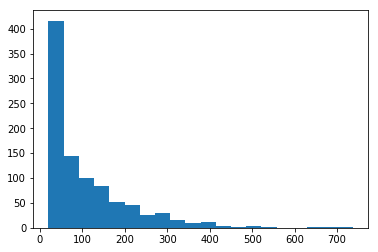

In [263]:
plt.hist(user_rated_count, bins = 20)
plt.show()

In [260]:
# we try to set the threshold as the median now and see how it goes
threshold = median(user_rated_count)
threshold

65.0

In [266]:
# divide main train matrix into two smaller matrix according to threshold set
rated_count_above_threshold_matrix = train_matrix[user_rated_count>threshold]
rated_count_below_threshold_matrix = train_matrix[user_rated_count<=threshold]

In [270]:
def predict_new(train_matrix, base):
    if base == 'user':
        ########### your code goes here ###########
        #generate a same size matrix as train_matrix with 0s
        temp_matrix = np.zeros(train_matrix.shape)

        # add 1s if user has already rated a movie (no need to normalize later)
        temp_matrix[train_matrix.nonzero()] = 1

        # calculate user user similarity for cosine
        uu_similarity = 1 - pairwise_distances(train_matrix, metric='cosine')

        #calculater normalizer (denominator) - sum of all other user's similarity to target user's target movie 
        normalizer = np.matmul(uu_similarity, temp_matrix)

        # need to add a small number for normalizer to avoid dividing by 0
        normalizer[normalizer==0] =1e-5

        # matrix multiplication - user-similarity * their rating, and normalize
        predictionMatrix = np.matmul(uu_similarity, train_matrix)/normalizer

        # calculate user average for later use(in case no one rated a movie, use user average)
        useraverage = np.sum(train_matrix, axis=1)/(np.sum(temp_matrix, axis=1) + 1e-5)

        # sum up predicted ratings for each item (identify items with 0 ratings)
        columns = np.sum(predictionMatrix, axis=0)

        # for those with 0 ratings, assign user's average rating
        predictionMatrix[:, columns==0] = predictionMatrix[:, columns==0] + np.expand_dims(useraverage, axis=1)

        return predictionMatrix

        ###########         end         ###########

    elif base == 'item':
        ########### your code goes here ###########
        # turn 943 * 1682 into 1682 * 943
        train_matrix = train_matrix.T

        #generate a same size matrix as train_matrix with 0s
        temp_matrix = np.zeros(train_matrix.shape)

        # add 1s if user has already rated a movie (no need to normalize later)
        temp_matrix[train_matrix.nonzero()] = 1

        # 1682 * 1682
        ii_similarity = 1 - pairwise_distances(train_matrix, metric='cosine')

        normalizer = np.matmul(ii_similarity, temp_matrix)
        normalizer[normalizer==0] = 1e-5
        predictionMatrix = np.matmul(ii_similarity, train_matrix)/normalizer

        itemaverage = np.sum(train_matrix, axis=1)/(np.sum(temp_matrix, axis=1) + 1e-5)
        columns = np.sum(predictionMatrix, axis=0)
        predictionMatrix[:, columns==0] = predictionMatrix[:, columns==0] + np.expand_dims(itemaverage, axis=1)

        return predictionMatrix.T

        ###########         end         ###########
    else:
        print('No other option available')

In [264]:
def rmse(pred, test):
    # calculate RMSE for all the items in the test dataset
    predItems = pred[test.nonzero()].flatten() 
    testItems = test[test.nonzero()].flatten()
    return sqrt(mean_squared_error(predItems, testItems))

In [271]:
predict_new(rated_count_above_threshold_matrix,"user").shape

(466, 1682)

In [272]:
predict_new(rated_count_below_threshold_matrix,"user").shape

(477, 1682)

In [278]:
# check if dimention matches
len(rating_df.userID.unique()) == predict_new(rated_count_above_threshold_matrix,"user").shape[0] + predict_new(rated_count_below_threshold_matrix,"user").shape[0]

True

In [284]:
num_items

1682

In [287]:
def getData(folder_path, file_name):
    fields = ['userID', 'itemID', 'rating', 'timestamp']
    data = pd.read_csv(os.path.join(folder_path, file_name), sep='\t', names=fields)
    return data 

In [295]:
# get train data_df
train_df_1 = getData(MOVIELENS_DIR, 'u1.base')
train_df_2 = getData(MOVIELENS_DIR, 'u2.base')
train_df_3 = getData(MOVIELENS_DIR, 'u3.base')
train_df_4 = getData(MOVIELENS_DIR, 'u4.base')
train_df_5 = getData(MOVIELENS_DIR, 'u5.base')

# test data df
test_df_1 = getData(MOVIELENS_DIR, 'u1.test')
test_df_2 = getData(MOVIELENS_DIR, 'u2.test')
test_df_3 = getData(MOVIELENS_DIR, 'u3.test')
test_df_4 = getData(MOVIELENS_DIR, 'u4.test')
test_df_5 = getData(MOVIELENS_DIR, 'u5.test')

In [306]:
def threshold_rmse(train_df, test_df):
    
    # Building User-to-Item Rating Matrix for train and test data
    user_item_matrix_train = dataPreprocessor(train_df,num_users,num_items)
    user_item_matrix_test = dataPreprocessor(test_df,num_users,num_items)
    
    # split main train user-item rating matrix into two sub-matrix based on user_rated_count(threshold)
    rated_above_matrix_train = user_item_matrix_train[user_rated_count>threshold] 
    rated_below_matrix_train = user_item_matrix_train[user_rated_count<=threshold]
    
    # split main test user-item rating matrix into two sub-matrix based on user_rated_count(threshold)
    rated_above_matrix_test = user_item_matrix_test[user_rated_count>threshold]
    rated_below_matrix_test = user_item_matrix_test[user_rated_count<=threshold]
    
    # for user-user cosine similarity prediction , predict ratings for both above and below dataset
    user_cosine_above = predict_new(rated_above_matrix_train, "user")
    user_cosine_below = predict_new(rated_below_matrix_train, "user")
    
    # for item-item cosine similarity prediction , predict ratings for both above and below dataset
    item_cosine_above = predict_new(rated_above_matrix_train, "item")
    item_cosine_below = predict_new(rated_below_matrix_train, "item")
    
    #calculate rmse between above results and target test matrics
    rmse_user_above = rmse(user_cosine_above, rated_above_matrix_test)
    rmse_user_below = rmse(user_cosine_below, rated_below_matrix_test)
    
    rmse_item_above = rmse(item_cosine_above, rated_above_matrix_test)
    rmse_item_below = rmse(item_cosine_below, rated_below_matrix_test)
    
    print("rmse_user_above: " + str(rmse_user_above) + "\n"
          "rmse_user_below: " + str(rmse_user_below) + "\n"
          "rmse_item_above: " + str(rmse_item_above) + "\n"
          "rmse_item_below: " + str(rmse_item_below))

In [307]:
threshold_rmse(train_df_1, test_df_1)

rmse_user_above: 1.0217224238522409
rmse_user_below: 1.0925082986968262
rmse_item_above: 1.0420718763092183
rmse_item_below: 1.1591606785239992


In [308]:
threshold_rmse(train_df_2, test_df_2)

rmse_user_above: 1.0120730496853942
rmse_user_below: 1.1125380537421266
rmse_item_above: 1.019209168113586
rmse_item_below: 1.1457109707029796


In [309]:
threshold_rmse(train_df_3, test_df_3)

rmse_user_above: 1.0077844097606357
rmse_user_below: 1.0896662791465428
rmse_item_above: 1.0071054788694778
rmse_item_below: 1.1384712875365235


In [310]:
threshold_rmse(train_df_4, test_df_4)

rmse_user_above: 1.0014319590057332
rmse_user_below: 1.0980748043537147
rmse_item_above: 1.009676620888213
rmse_item_below: 1.1323950504334444


In [311]:
threshold_rmse(train_df_5, test_df_5)

rmse_user_above: 1.010699717208189
rmse_user_below: 1.1042194022963487
rmse_item_above: 1.0184146217690633
rmse_item_below: 1.1092489872604028


 * **unsuperisingly, user-cosine out performed item cosine for above and below threshold respectively.**
 * **user-rated more than threshold (65) have a better rmse value compare to those who rated fewer than threshold**
 * **people who rated more movies once got splited into separated train matrix, uer-item matrix will be denser -> result in a more features train data.(note the # above vs # below is 466vs477)**

###### Validation

In [285]:
train_df_1 = getData(MOVIELENS_DIR, 'u1.base')

In [312]:
# Constants for validation only
ROW_NUM = 943
COL_NUM = 1682
RATING_COL = 'rating'

### dataPreprocessor

In [313]:
def validateDataPreprocessor(path=MOVIELENS_DIR, getData=getData, getMatrix=CrossValidation.getMatrix):
    validation_df = getData(MOVIELENS_DIR, 'u1.test')
    try:
        matrix = getMatrix(validation_df, ROW_NUM, COL_NUM, RATING_COL)
    except:
        print('dataPreprocessor function has error')
        return
    try:
        assert(matrix.shape == (ROW_NUM,COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape (943,1682)".format(matrix.shape)
    except Exception as e:
        print(e)
    return validation_df

In [314]:
validateDataPreprocessor()

,userID,itemID,rating,timestamp
0,1,6,5,887431973
1,1,10,3,875693118
2,1,12,5,878542960
3,1,14,5,874965706
4,1,17,3,875073198
5,1,20,4,887431883
6,1,23,4,875072895
7,1,24,3,875071713
8,1,27,2,876892946
9,1,31,3,875072144


## Baseline Recommendation Systems

### Popularity Based Recommendation

In [315]:
def validatePopularityRecSys(validation_df=validation_df, BaseLineRecSys = BaseLineRecSys):
    popularity_recsys = BaseLineRecSys('popularity')
    try:
        popularity_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
    except Exception as e:        
        print('popularity function has error')
        print(e)
        return
    try:
        predictionMatrix = popularity_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [316]:
validatePopularityRecSys()

calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


### User Average Based Recommendation

In [317]:
def validateUserAverRecSys(validation_df=validation_df, BaseLineRecSys = BaseLineRecSys):
    useraverage_recsys = BaseLineRecSys('average_user_rating')
    try:
        useraverage_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
    except:
        print('useraverage function has error')
        return
    try:
        predictionMatrix = useraverage_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [318]:
validatePopularityRecSys()

calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


## Similary Based Recommendation Systems

### Euclidean Similarity Function

In [319]:
def validateEuclidean(validation_df=validation_df, getMatrix=CrossValidation.getMatrix):
    matrix = getMatrix(validation_df, ROW_NUM, COL_NUM, RATING_COL)
    try:
        sim_matrix = SimBasedRecSys.euclidean(matrix)
        assert(sim_matrix.shape == (ROW_NUM, ROW_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(sim_matrix.shape,ROW_NUM,ROW_NUM)
        assert(np.any(sim_matrix <= 1)),\
               "Exist similarity value that is not less or equal to 1."
    except Exception as e:
        print(e)        

In [320]:
validateEuclidean()

### Customized Similarity Function (test somethingelse function)

In [321]:
def validateCustomizedSim(validation_df=validation_df, getMatrix=CrossValidation.getMatrix):
    matrix = getMatrix(validation_df, ROW_NUM, COL_NUM, RATING_COL)
    try:
        sim_matrix = SimBasedRecSys.somethingelse(matrix)
        assert(sim_matrix.shape == (ROW_NUM, ROW_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(sim_matrix.shape,ROW_NUM,ROW_NUM)
        assert(np.any(sim_matrix <= 1)),\
               "Exist similarity value that is not less or equal to 1."
    except Exception as e:
        print(e) 

In [322]:
validateCustomizedSim()

### User-User Similarity Based Recommendation System

In [323]:
def validateUUSimBasedRecSys(validation_df=validation_df, dataPreprocessor=dataPreprocessor):
    try:
        user_cosine_recsys = SimBasedRecSys('user','cosine', dataPreprocessor)
    except:
        print("Framework error, please make sure you are using given yml file.")
        return
    
    try:
        user_cosine_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
        predictionMatrix = user_cosine_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [324]:
validateUUSimBasedRecSys()

### Item-Item Similarity Based Recommendation System

In [325]:
def validateIISimBasedRecSys(validation_df=validation_df, dataPreprocessor=dataPreprocessor):
    try:
        user_cosine_recsys = SimBasedRecSys('item','cosine', dataPreprocessor)
    except:
        print("Framework error, please make sure you are using given yml file.")
        return
    
    try:
        user_cosine_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
        predictionMatrix = user_cosine_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [326]:
validateIISimBasedRecSys()